# **1 Peak Finding and Molecule Identificaiton**

This notebook if or finding peaks in the data cube and identifying a molcule and changin the rest mass in the file.

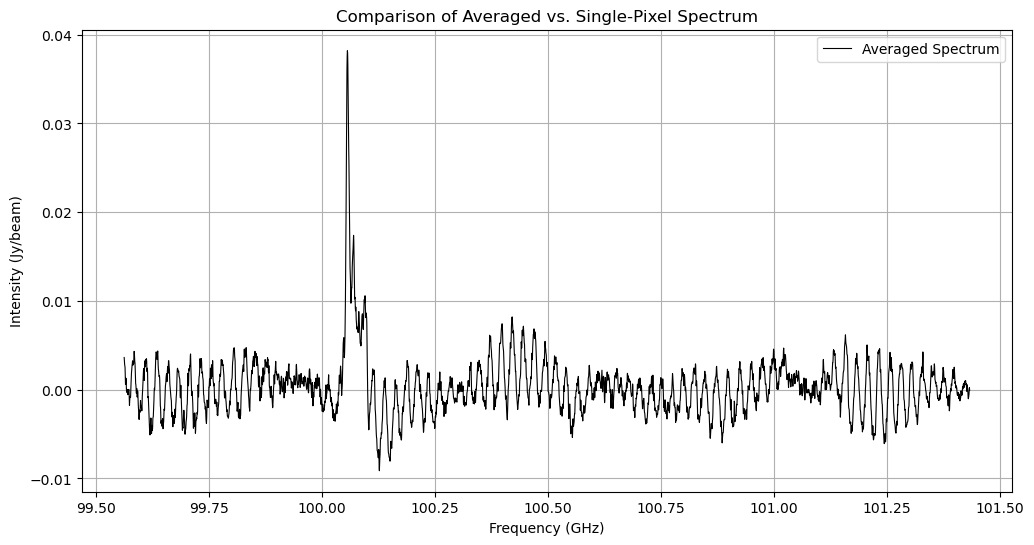

In [1]:
#Full spectrum extracted and plotted to display and find peaks in the data, easier than looking in CARTA

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Load the FITS file
fits_file = "data/New_Data/ACES_project_data/Sgr_A_st_ai.TP_7M_feather_all.SPW_35.image.statcont.contsub.fits"  # Change to actual filename
hdul = fits.open(fits_file)

# Extract spectral axis info from the header
header = hdul[0].header
crval3 = header['CRVAL3'] / 1e9  # Convert Hz to GHz (starting frequency)
cdelt3 = header['CDELT3'] / 1e9  # Convert Hz to GHz (channel width)
naxis3 = header['NAXIS3']  # Number of spectral channels

# Generate the frequency axis
frequencies = crval3 + np.arange(naxis3) * cdelt3

# Extract intensity data (3D cube)
data_cube = hdul[0].data  # Shape: (3834, 278, 308)

# Choose a representative pixel (near the center)
x_idx, y_idx = 139, 154  # Adjust if needed
intensity_single_pixel = data_cube[:, y_idx, x_idx]

# Average over all pixels
intensity_avg = np.nanmean(data_cube, axis=(1, 2))  # Mean over spatial axes

# Close FITS file
hdul.close()

# Plot both spectra
plt.figure(figsize=(12, 6))
plt.plot(frequencies, intensity_avg, color='black', linewidth=0.8, label="Averaged Spectrum")
#plt.plot(frequencies, intensity_single_pixel, color='red', linewidth=0.8, linestyle='dashed', label="Single-Pixel Spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (Jy/beam)")
plt.title("Comparison of Averaged vs. Single-Pixel Spectrum")
plt.legend()
plt.grid()
plt.show()


## **Peak has been located, next cell zooms and crops a region round the peak of interest**

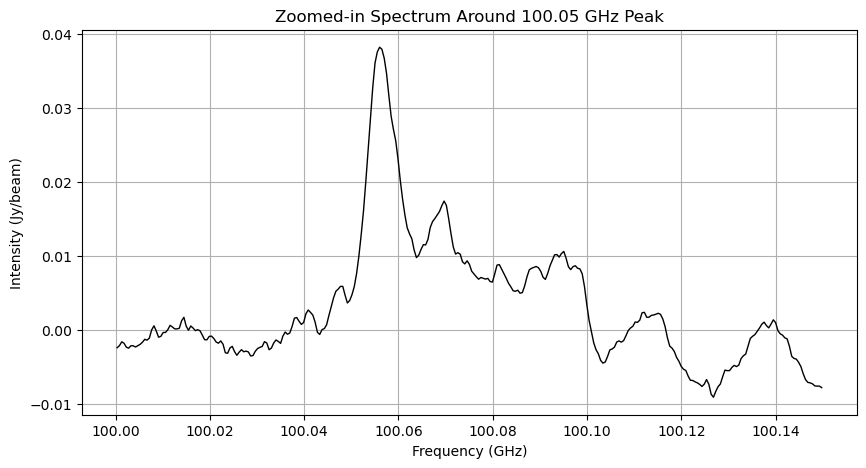

In [2]:
# Define the zoom-in range around the strong peak
zoom_min = 100.00 # GHz
zoom_max = 100.15 # GHz

# Extract the indices for this frequency range
zoom_indices = np.where((frequencies >= zoom_min) & (frequencies <= zoom_max))[0]

# Get zoomed-in frequency and intensity values
frequencies_zoomed = frequencies[zoom_indices]
intensity_zoomed = intensity_avg[zoom_indices]  # Using the averaged spectrum

# Plot the zoomed-in spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies_zoomed, intensity_zoomed, color='black', linewidth=1)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (Jy/beam)")
plt.title(f"Zoomed-in Spectrum Around {100.05} GHz Peak")
plt.grid()
plt.show()


## **Simple gaussian fitting to roughly find the peak frequency and width for then referencing against the catalogou of transition lines**

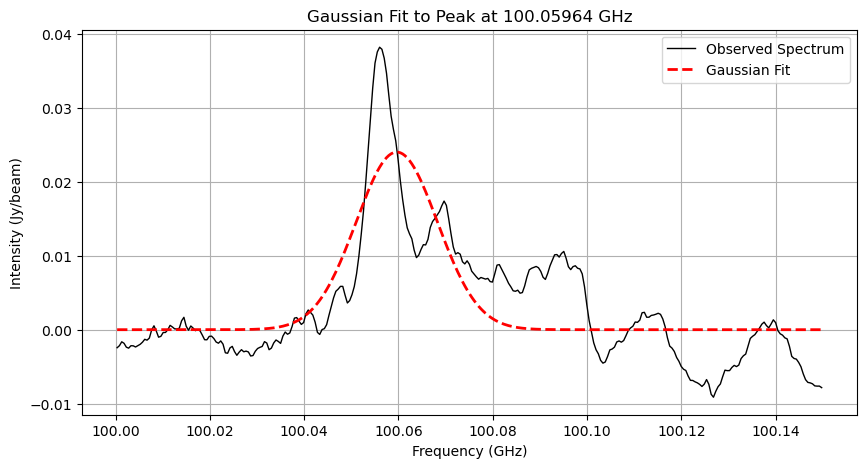

 Peak Frequency: 100.05964 GHz
 Peak Amplitude: 0.02402 Jy/beam
 Peak Width (FWHM): 0.02030 GHz


In [3]:
from scipy.optimize import curve_fit

# Define a Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Estimate initial parameters (A = peak intensity, mu = peak location, sigma = rough width)
A_guess = np.max(intensity_zoomed)
mu_guess = frequencies_zoomed[np.argmax(intensity_zoomed)]
sigma_guess = 0.005  # Approximate initial guess for width

# Fit the Gaussian to the data
popt, pcov = curve_fit(gaussian, frequencies_zoomed, intensity_zoomed, p0=[A_guess, mu_guess, sigma_guess])

# Extract best-fit parameters
A_fit, mu_fit, sigma_fit = popt

# Compute Full Width at Half Maximum (FWHM)
FWHM = 2.355 * sigma_fit  # Standard Gaussian FWHM formula

# Generate smooth Gaussian curve for plotting
fit_curve = gaussian(frequencies_zoomed, *popt)

# Plot the zoomed-in spectrum with the Gaussian fit
plt.figure(figsize=(10, 5))
plt.plot(frequencies_zoomed, intensity_zoomed, color='black', linewidth=1, label="Observed Spectrum")
plt.plot(frequencies_zoomed, fit_curve, color='red', linestyle="dashed", linewidth=2, label="Gaussian Fit")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (Jy/beam)")
plt.title(f"Gaussian Fit to Peak at {mu_fit:.5f} GHz")
plt.legend()
plt.grid()
plt.show()

# Print the results
print(f" Peak Frequency: {mu_fit:.5f} GHz")
print(f" Peak Amplitude: {A_fit:.5f} Jy/beam")
print(f" Peak Width (FWHM): {FWHM:.5f} GHz")


## **Enter here possible transitions lines for the peak, code suggests the most probable molecule for that line**

In [4]:
# List of candidate molecules and their rest frequencies
molecules = {
    "HC3N 11-10": 100.0763,
    "SO 4(5)-4(4)": 100.02956,
    "H2CCO": 100.094514
}

# Observed frequency
nu_obs = mu_fit  # GHz
c = 3.0e5  # Speed of light in km/s

# Check each molecule
best_match = None
best_velocity_diff = float('inf')

print("=== Velocity Shift Comparison ===")
for molecule, nu_rest in molecules.items():
    # Compute velocity shift
    velocity_shift = c * ((nu_rest**2 - nu_obs**2) / (nu_rest**2 + nu_obs**2))
    
    # Display result
    print(f"{molecule}: Velocity Shift Needed = {velocity_shift:.2f} km/s")
    
    # Check if within expected range
    if 40 <= abs(velocity_shift) <= 80:
        print(f"{molecule} fits within the expected velocity range!")
        
        # Find the best match (smallest deviation from expected range)
        deviation = min(abs(velocity_shift - 50), abs(velocity_shift - 80))
        if deviation < best_velocity_diff:
            best_velocity_diff = deviation
            best_match = molecule
    else:
        print(f"⚠️ {molecule} is outside the expected velocity range.")

# Display best match
if best_match:
    print(f"\n **Best match based on velocity correction: {best_match}!**")
else:
    print("\n⚠️ No perfect match found within the 50-80 km/s range. Consider other explanations.")


=== Velocity Shift Comparison ===
HC3N 11-10: Velocity Shift Needed = 49.95 km/s
HC3N 11-10 fits within the expected velocity range!
SO 4(5)-4(4): Velocity Shift Needed = -90.20 km/s
⚠️ SO 4(5)-4(4) is outside the expected velocity range.
H2CCO: Velocity Shift Needed = 104.55 km/s
⚠️ H2CCO is outside the expected velocity range.

 **Best match based on velocity correction: HC3N 11-10!**


## **Next cell is used for cropping the data set round peal**

In [5]:
import numpy as np
from astropy.io import fits

# Load the FITS file
filename = 'data/New_Data/ACES_project_data/Sgr_A_st_ai.TP_7M_feather_all.SPW_35.image.statcont.contsub.fits' 
with fits.open(filename) as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

# Confirm the data shape
print(f"Data shape: {data_cube.shape}")  # Should be (Frequency, DEC, RA)

# Frequency metadata from FITS
CRVAL3 = header['CRVAL3'] / 1e9  # Convert Hz to GHz
CDELT3 = header['CDELT3'] / 1e9  # Convert Hz to GHz
NAXIS3 = header['NAXIS3']  # Number of frequency channels

# Define frequency axis correctly
freqs = CRVAL3 + np.arange(NAXIS3) * CDELT3  # Compute real frequency steps

# Define desired frequency range
freq_min = 100.03  # GHz
freq_max = 100.13  # GHz

# Find the closest indices to the requested range
closest_min_idx = np.argmin(np.abs(freqs - freq_min))
closest_max_idx = np.argmin(np.abs(freqs - freq_max))

# Extract the corresponding data slice
freq_indices = np.arange(closest_min_idx, closest_max_idx + 1)
if freq_indices.size > 0:
    extracted_data = data_cube[freq_indices, :, :]

    # Update the FITS header
    new_header = header.copy()
    new_header['NAXIS3'] = len(freq_indices)  # Update frequency axis length
    new_header['CRVAL3'] = freqs[closest_min_idx] * 1e9  # Convert back to Hz
    new_header['CDELT3'] = CDELT3 * 1e9  # Convert back to Hz

    # Save the extracted data
    new_filename = f'ai_35_{freq_min:.4f}_{freq_max:.4f}.fits'
    fits.writeto(new_filename, extracted_data, header=new_header, overwrite=True)
    print(f"Extracted data saved to '{new_filename}'")

else:
    print("No frequencies found in the specified range.")


Data shape: (3834, 278, 308)
Extracted data saved to 'ai_35_100.0300_100.1300.fits'


## **Now we have the fits file with the correct cropped region, the next step is to change the rest frequency to the desired molecule tranisiton line rest frequency**

In [6]:
import numpy as np
from astropy.io import fits

# Set the molecule name and its rest frequency (GHz)
chosen_molecule = ""  # Change this to test different molecules
chosen_rest_freq = 100.0763 # Change this value to the correct rest frequency

print(f"Using {chosen_molecule} with rest frequency {chosen_rest_freq:.6f} GHz")

# Load the FITS file
filename = 'ai_35_100.0300_100.1300.fits'  # Update with your extracted file
with fits.open(filename) as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

# Constants
c = 299792.458  # Speed of light in km/s

# Extract frequency axis metadata
CRVAL3 = header['CRVAL3'] / 1e9  # Convert Hz to GHz
CDELT3 = header['CDELT3'] / 1e9  # Convert Hz to GHz
NAXIS3 = header['NAXIS3']

# Generate the observed frequency axis
freqs_obs = CRVAL3 + np.arange(NAXIS3) * CDELT3

# Convert frequency axis to velocity using the correct radio definition
velocities = c * (chosen_rest_freq - freqs_obs) / chosen_rest_freq  # V_radio

# Optional: Use optical velocity if required by CARTA
use_optical_velocity = False  # Set to True if needed
if use_optical_velocity:
    velocities = c * (freqs_obs - chosen_rest_freq) / freqs_obs  # V_optical

# Fix the velocity step size (CDELT3)
velocity_step = c * (CDELT3 / chosen_rest_freq)

# Ensure proper velocity axis formatting
updated_header = header.copy()
updated_header['RESTFRQ'] = chosen_rest_freq * 1e9  # Store in Hz
updated_header['CTYPE3'] = 'VRAD'  # Velocity reference
updated_header['CUNIT3'] = 'km/s'  # Velocity unit
updated_header['CRVAL3'] = c * ((chosen_rest_freq - header['CRVAL3'] / 1e9) / chosen_rest_freq)  # Correct velocity reference
updated_header['CDELT3'] = -velocity_step  # Correct velocity step size

print(f"FITS header updated with RESTFRQ = {chosen_rest_freq:.6f} GHz and velocity axis formatting.")

# Save the new FITS file with the molecule name
new_filename = f'{chosen_molecule}.fits'
fits.writeto(new_filename, data_cube, updated_header, overwrite=True)

print(f"Updated FITS file saved: {new_filename}")


Using  with rest frequency 100.076300 GHz
FITS header updated with RESTFRQ = 100.076300 GHz and velocity axis formatting.
Updated FITS file saved: .fits


## **At this stage, a fits file of a cropped region with the desired rest frequency has been produced. The next steps, in the next file, will be our analysis and moment map creation**